In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib
import matplotlib.pyplot as plt

import generate as generate
from single_layer import *

In [19]:
filename="../results.xlsx"

In [20]:
data = pd.read_excel(filename)
data = data.groupby(['d', 'M', 'T', 'noise', 'model']).agg(
    regret_mean=pd.NamedAgg(column="regret", aggfunc="mean"),
    regret_median=pd.NamedAgg(column="regret", aggfunc="median"),
    regret_std=pd.NamedAgg(column="regret", aggfunc="std"),
    count=pd.NamedAgg(column="regret", aggfunc="count"),
).reset_index()
data["regret_std"] /= np.sqrt(data["count"])
data["epsilon"] = data["regret_mean"] / (data["M"] / 2 / data["noise"] / data["noise"])
data["epsilon_std"] = data["regret_std"] / (data["M"] / 2 / data["noise"] / data["noise"])
data

,d,M,T,noise,model,regret_mean,regret_median,regret_std,count,epsilon,epsilon_std
0,8,1,256,0.1,"[128, 128, 128]",5.841861,2.705932,1.066515,64,0.116837,0.021330
1,8,1,256,0.1,"[16, 16, 16]",5.973258,3.180697,1.285947,32,0.119465,0.025719
2,8,1,256,0.1,"[32, 32, 32]",4.707500,2.491046,1.031473,32,0.094150,0.020629
3,8,1,256,0.1,"[64, 64, 64]",4.392853,1.719504,0.759747,64,0.087857,0.015195
4,8,1,512,0.1,"[128, 128, 128]",2.170476,1.137112,0.313782,64,0.043410,0.006276
5,8,1,512,0.1,"[16, 16, 16]",3.196856,1.194938,0.891011,32,0.063937,0.017820
6,8,1,512,0.1,"[32, 32, 32]",2.368689,1.052488,0.423890,48,0.047374,0.008478
7,8,1,512,0.1,"[64, 64, 64]",3.621913,1.579076,0.557628,64,0.072438,0.011153
8,8,1,1024,0.1,"[128, 128, 128]",1.728345,0.824981,0.283528,64,0.034567,0.005671
9,8,1,1024,0.1,"[16, 16, 16]",2.304675,0.731095,0.500182,32,0.046094,0.010004


In [21]:
data.loc[data.groupby(['d', 'M', 'T', 'noise'])['regret_mean'].idxmin()].reset_index()

,index,d,M,T,noise,model,regret_mean,regret_median,regret_std,count,epsilon,epsilon_std
0,3,8,1,256,0.1,"[64, 64, 64]",4.392853,1.719504,0.759747,64,0.087857,0.015195
1,4,8,1,512,0.1,"[128, 128, 128]",2.170476,1.137112,0.313782,64,0.043410,0.006276
2,11,8,1,1024,0.1,"[64, 64, 64]",1.392100,0.730678,0.217506,64,0.027842,0.004350
3,12,8,1,2048,0.1,"[128, 128, 128]",1.130313,0.662609,0.147124,64,0.022606,0.002942
4,16,8,1,4096,0.1,"[128, 128, 128]",1.057082,0.550700,0.163508,64,0.021142,0.003270
5,20,8,1,8192,0.1,"[128, 128, 128]",0.698581,0.508957,0.100627,64,0.013972,0.002013
6,24,8,2,512,0.1,"[128, 128, 128]",6.716343,3.511193,1.017282,64,0.067163,0.010173
7,26,8,2,1024,0.1,"[128, 128, 128]",4.747167,4.047618,0.468621,64,0.047472,0.004686
8,28,8,2,2048,0.1,"[128, 128, 128]",2.744320,1.676967,0.395751,64,0.027443,0.003958
9,31,8,2,4096,0.1,"[64, 64, 64]",2.586977,1.631974,0.316711,64,0.025870,0.003167


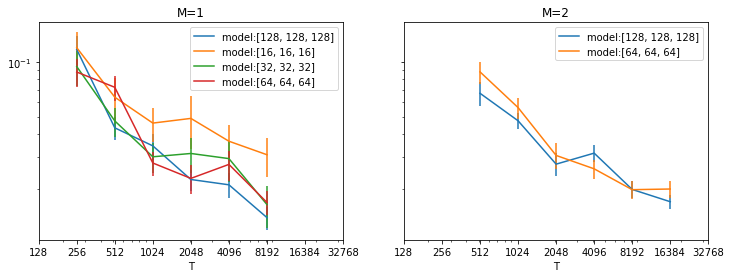

In [22]:
grouped = data.set_index('T').groupby(['M'])
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,4), sharey=True)
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    grouped2 = grouped.get_group(key).groupby('model')
    for key2 in grouped2.groups.keys():
        grouped2.get_group(key2).plot(
            ax=ax, 
            legend=True,
            logx=True,
            logy=True,
            y='epsilon',
            yerr='epsilon_std',
            label=f'model:{key2}',
        )
    ax.set_title(f'M={key}')
    ax.set_xticks(np.exp2(np.arange(7, 16)))
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.legend()
plt.show()
#.plot(legend=True, logx=True)

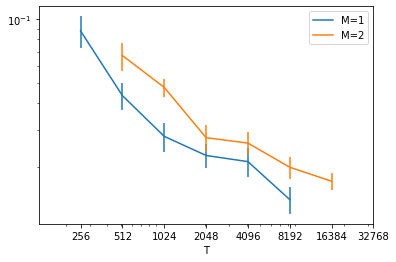

In [23]:
fig1, ax1 = plt.subplots()
grouped = data.loc[
    data.groupby(['d', 'M', 'T', 'noise'])['regret_mean'].idxmin()
].reset_index().set_index('T').groupby([
    'M'
])
for key in grouped.groups.keys():
    grouped.get_group(key).plot(
        legend=True,
        logx=True,
        logy=True,
        ax=ax1,
        y='epsilon',
        yerr='epsilon_std',
        label=f'M={key}',
    )
ax1.set_xticks(np.exp2(np.arange(7, 15)))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_xticks(np.exp2(np.arange(8, 16)))
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

In [24]:
d = 8
M = 2
noise = 0.1
epsilon = 0.05
d * M * M * np.log(1 / (M * noise * noise * epsilon * np.log(1 + 1 / noise / noise) ))

172.10935351071478

In [25]:
def get_T_e(data, epsilon):
    return data.where(data['epsilon'] < epsilon).groupby(['d', 'M', 'noise']).agg(
        T_e = pd.NamedAgg(column="T", aggfunc="min"),
    ).reset_index()

In [26]:
get_T_e(data, 0.05)

,d,M,noise,T_e
0,8.0,1.0,0.1,512.0
1,8.0,2.0,0.1,1024.0


In [27]:
get_T_e(data, 0.025)

,d,M,noise,T_e
0,8.0,1.0,0.1,2048.0
1,8.0,2.0,0.1,8192.0
